# Classification of Sentinel-1  Time Series

SAR data are not especially good for vegetation classification. However they have the great advantage of being independent of cloud cover. Here we investigate the use of S1 time series over a complete growth period for thematic mapping.

Since we have no ground truth data, we will use the Canada AAFC Annual Crop Inventory, which is also on the GEE archive. In particular the 2017 inventory for an area in southern Saskatchewan. This area consists of large agricultural fields, well-defined crops, and flat terrain (a big advantage for SAR measurement).

Multilook SAR image data are not normally distributed, rather they are gamma distributed. The GEE classifiers might be expected not to work so well, so we will use Tensorflow to program a more flexible neural network classifier.

__First of all we grab a time series for the region of interest over the 2017 growing season (March to October):__

In [1]:
%matplotlib inline
import ee
from auxil.eeWishart import omnibus
from auxil.eeRL import refinedLee
import math

def get_vvvh(image):   
    ''' get 'VV' and 'VH' bands from sentinel-1 imageCollection and restore linear signal from db-values '''
    return image.select('VV','VH').multiply(ee.Image.constant(math.log(10.0)/10.0)).exp()

ee.Initialize()
poly = ee.Geometry({'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-96.37148242476574, 49.743194032265315], 
                                                                           [-96.14121447141116, 49.743194032265315], 
                                                                           [-96.14121447141116, 49.86841882771481],
                                                                           [-96.37148242476574, 49.86841882771481], 
                                                                           [-96.37148242476574, 49.743194032265315]]]})
collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
                      .filterBounds(poly) \
                      .filterDate(ee.Date('2018-03-01'), ee.Date('2018-11-01')) \
                      .filter(ee.Filter.eq('transmitterReceiverPolarisation', ['VV','VH'])) \
                      .filter(ee.Filter.eq('resolution_meters', 10)) \
                      .filter(ee.Filter.eq('instrumentMode', 'IW')) \
                      .filter(ee.Filter.eq('relativeOrbitNumber_start',63)) \
                      .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))  
collection = collection.sort('system:time_start')

collection.size().getInfo()

20

#### Next run the cd algorithm to get the filtered image time series as a multiband image

In [2]:
from auxil.eeWishart import omnibus

result = omnibus(collection.map(get_vvvh).toList(100),0.05,4.4,True)
avimgs = ee.List(result.get('avimgs'))
print(avimgs.length().getInfo())
timeseries_atsf = ee.ImageCollection(avimgs).toBands().clip(poly).float()
print(timeseries_atsf.bandNames().length().getInfo())

20
40


__Next, we transform the collection into two additional multiband images with linear intensities, one pre-processed with the refined Lee filter and one not:__

In [3]:

timeseries_rl = collection \
            .map(get_vvvh) \
            .map(refinedLee) \
            .toBands() \
            .clip(poly) \
            .float()    

timeseries_raw = collection \
            .map(get_vvvh) \
            .toBands() \
            .clip(poly) \
            .float()          

timeseries_rl.bandNames().length().getInfo()

40

__The class lables are conveniently obtained from the GEE archive of the Canadian AAFC Annual Crop Inventory for the year 2017, and we append them as an additional band (band 39):__ 

In [4]:
crop2017 = ee.ImageCollection('AAFC/ACI') \
    .filter(ee.Filter.date('2018-01-01', '2018-12-01')) \
    .first() \
    .clip(poly)\
    .float()

labeled_timeseries_rl = ee.Image.cat(timeseries_rl,crop2017)
labeled_timeseries_raw = ee.Image.cat(timeseries_raw,crop2017)
labeled_timeseries_atsf = ee.Image.cat(timeseries_atsf,crop2017)

labeled_timeseries_rl.bandNames().length().getInfo()

41

__Now export the three images to the Google drive (cloud storage would be better, but I don't have a billing account). Note that the export scale is 10m so as not to invalidate the ENL:__

In [5]:
drexport1 = ee.batch.Export.image.toDrive(labeled_timeseries_rl,
                  description='driveExportTask1', 
                  folder = 'EarthEngineImages',
                  fileNamePrefix='labeled_timeseries_rl',scale=10,maxPixels=1e10)
drexport1.start()
drexport2 = ee.batch.Export.image.toDrive(labeled_timeseries_raw,
                  description='driveExportTask2', 
                  folder = 'EarthEngineImages',
                  fileNamePrefix='labeled_timeseries_raw',scale=10,maxPixels=1e10)
drexport2.start()
drexport3 = ee.batch.Export.image.toDrive(labeled_timeseries_atsf,
                  description='driveExportTask3', 
                  folder = 'EarthEngineImages',
                  fileNamePrefix='labeled_timeseries_atsf',scale=10,maxPixels=1e10)
drexport3.start()

__After downloading from the drive to a local directory, we have:__

In [18]:
!ls  imagery/s1atsf

labeled_timeseries_atsf_sub.tif  labeled_timeseries_raw.tif
labeled_timeseries_atsf.tif	 labeled_timeseries_rl_sub.tif
labeled_timeseries_raw_sub.tif	 labeled_timeseries_rl.tif


__This displays three of the VV bands and the last (label) band:__

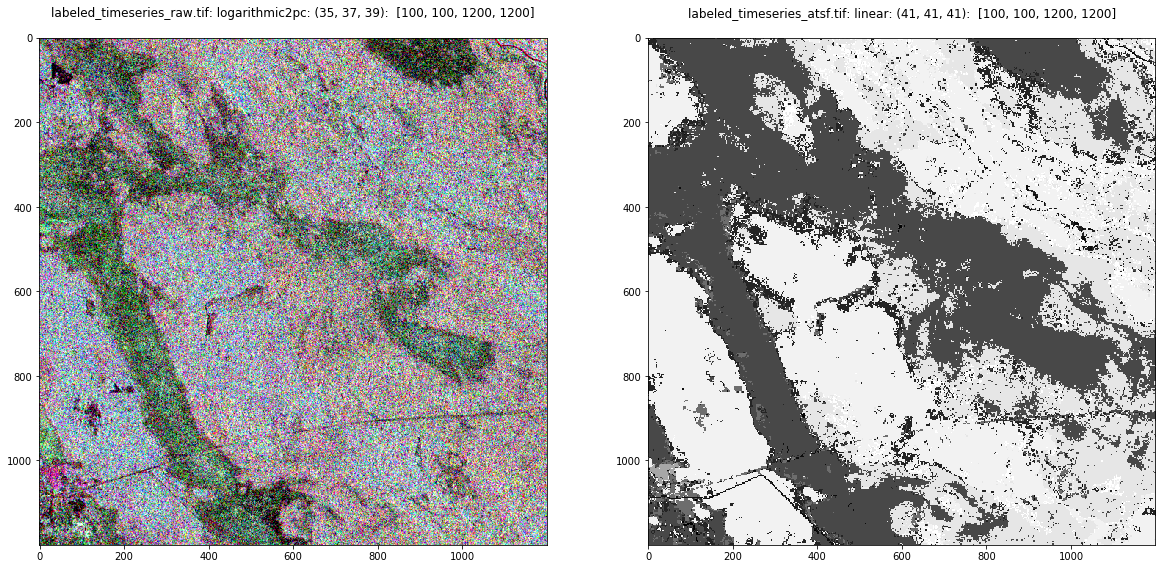

In [12]:
%run scripts/dispms -f imagery/s1atsf/labeled_timeseries_raw.tif -d [100,100,1200,1200]  -p [35,37,39] \
-F imagery/s1atsf/labeled_timeseries_atsf.tif -E 2 -D [100,100,1200,1200]   -P [41,41,41]

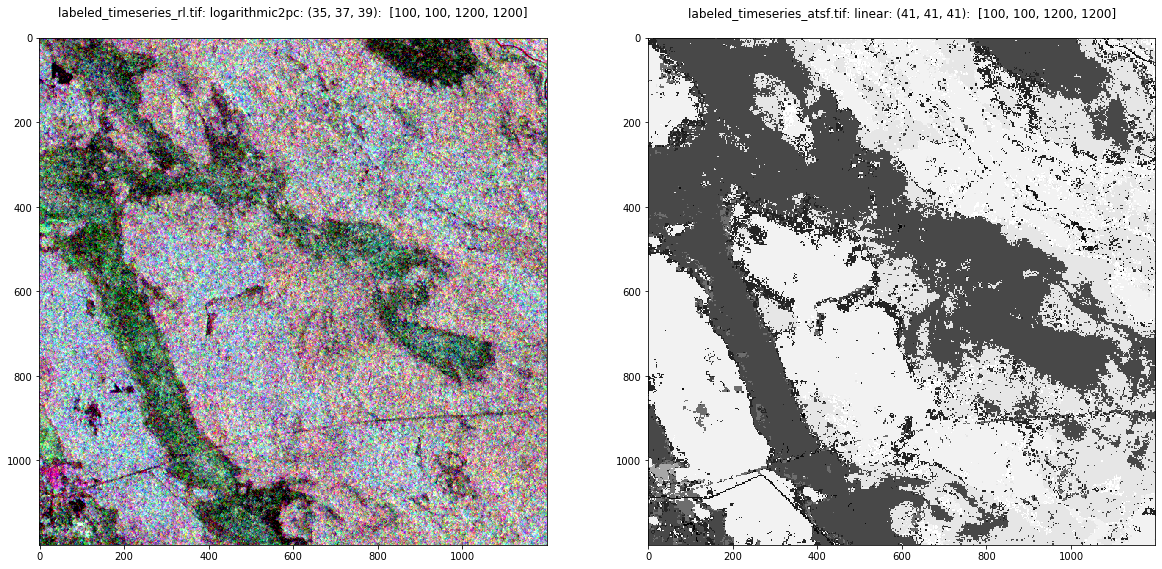

In [13]:
%run scripts/dispms -f imagery/s1atsf/labeled_timeseries_rl.tif -d [100,100,1200,1200]   -p [35,37,39] \
-F imagery/s1atsf/labeled_timeseries_atsf.tif -E 2 -D [100,100,1200,1200]  -P [41,41,41]

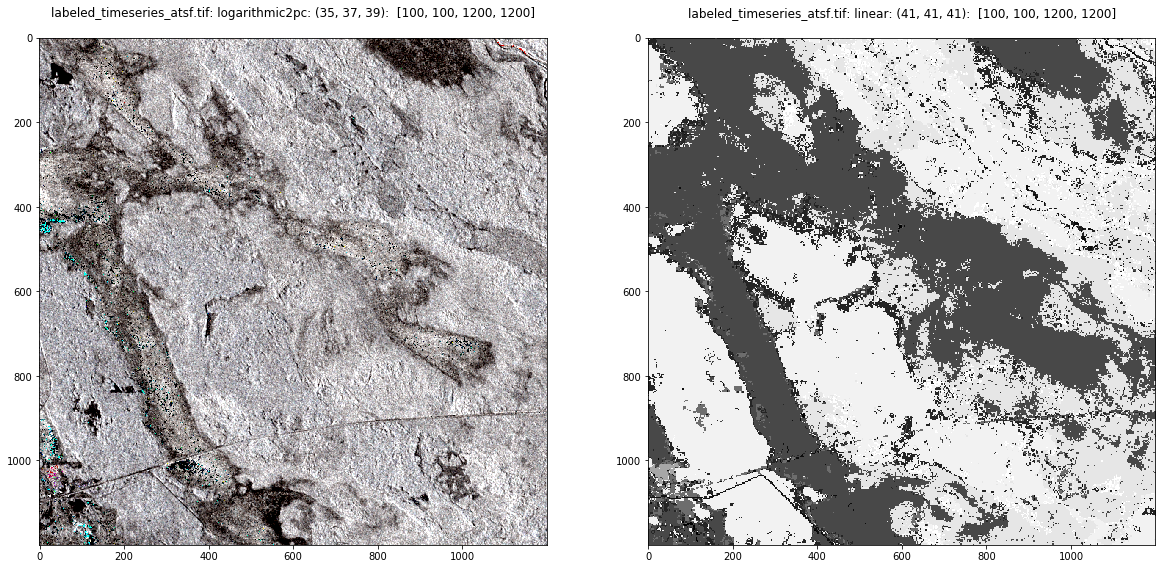

In [14]:
%run scripts/dispms -f imagery/s1atsf/labeled_timeseries_atsf.tif -d [100,100,1200,1200]   -p [35,37,39] \
-F imagery/s1atsf/labeled_timeseries_atsf.tif -E 2 -D [100,100,1200,1200]  -P [41,41,41]

#### Subset

In [17]:
%run auxil/subset -d [100,100,1200,1200] imagery/s1atsf/labeled_timeseries_raw.tif
%run auxil/subset -d [100,100,1200,1200] imagery/s1atsf/labeled_timeseries_rl.tif
%run auxil/subset -d [100,100,1200,1200] imagery/s1atsf/labeled_timeseries_atsf.tif

Spatial/spectral subsetting
Tue Jun 23 16:02:03 2020
Input imagery/s1atsf/labeled_timeseries_raw.tif
elapsed time: 8.53406047821045
Subset image written to: imagery/s1atsf/labeled_timeseries_raw_sub.tif
Spatial/spectral subsetting
Tue Jun 23 16:02:12 2020
Input imagery/s1atsf/labeled_timeseries_rl.tif
elapsed time: 8.400625228881836
Subset image written to: imagery/s1atsf/labeled_timeseries_rl_sub.tif
Spatial/spectral subsetting
Tue Jun 23 16:02:20 2020
Input imagery/s1atsf/labeled_timeseries_atsf.tif
elapsed time: 8.333836078643799
Subset image written to: imagery/s1atsf/labeled_timeseries_atsf_sub.tif


__Now read the labeled time series into three Numpy arrays, which we will use to train a Tensorflow NN classifier:__

In [19]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Byte
import numpy as np

gdal.AllRegister()                   
inDataset = gdal.Open('imagery/s1atsf/labeled_timeseries_raw_sub.tif',GA_ReadOnly)
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
bands = inDataset.RasterCount
labeled_timeseries_raw = np.zeros((rows*cols,bands))                              
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    labeled_timeseries_raw[:,b]=band.ReadAsArray(0,0,cols,rows).ravel()   
labeled_timeseries_raw = np.nan_to_num(labeled_timeseries_raw)    

inDataset = gdal.Open('imagery/s1atsf/labeled_timeseries_rl_sub.tif',GA_ReadOnly)
labeled_timeseries_rl = np.zeros((rows*cols,bands))                              
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    labeled_timeseries_rl[:,b]=band.ReadAsArray(0,0,cols,rows).ravel()   
labeled_timeseries_rl = np.nan_to_num(labeled_timeseries_rl)   

inDataset = gdal.Open('imagery/s1atsf/labeled_timeseries_atsf_sub.tif',GA_ReadOnly)
labeled_timeseries_atsf = np.zeros((rows*cols,bands))                              
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    labeled_timeseries_atsf[:,b]=band.ReadAsArray(0,0,cols,rows).ravel()   
labeled_timeseries_atsf = np.nan_to_num(labeled_timeseries_atsf)   

# for later
driver = inDataset.GetDriver() 
m = labeled_timeseries_raw.shape[0] 
inDataset = None

labeled_timeseries_raw.shape

(1440000, 41)

__The AAFC/ACI thematic maps have 68 different classes. This code generates a dictionary of class names:__

In [20]:
classdict = {'0':'Nc'}
filepath = 'imagery/AAFC.txt'
with open(filepath) as fp:
    line = fp.readline()
    key = line[:3].replace('\t','')
    value = line[10:].replace('\t',' ').replace('\n','')
    classdict.update({key:value})
    while line:
        line = fp.readline()
        key = line[:3].replace('\t','')
        value = line[10:].replace('\t','').replace('\n','')
        classdict.update({key:value})
del classdict['']

len(classdict)

68

__Now we can see which class labels pertain to our region of interest:__

In [21]:
classnums = np.unique(labeled_timeseries_rl[:,-1])
print(classnums)
classnames = str([classdict[str(int(cn))] for cn in classnums])
classnames

[ 20.  30.  34.  50.  80. 110. 122. 146. 153. 158. 210. 220. 230.]


"['Water', 'Exposed Land and Barren', 'Urban and Developed', 'Shrubland', 'Wetland', 'Grassland', 'Pasture and Forages', 'Spring Wheat', 'Canola and Rapeseed', 'Soybeans', 'Coniferous', 'Broadleaf', 'Mixedwood']"

__In order to train the neural network we have to renumber the labels consecutively from 0:__

In [22]:
i=0
labels = labeled_timeseries_rl[:,-1]
for c in classnums:
    labels = np.where(labels==c,i,labels)
    i += 1  
labels = np.array(labels,dtype=np.uint8) 
n_classes = len(np.unique(labels))
print(np.unique(labels))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12]


__Write the labels as an image to disk and display them:__

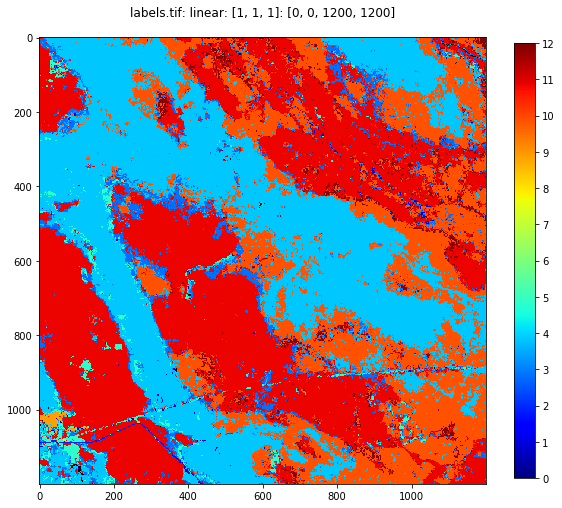

In [23]:
outDataset = driver.Create('imagery/s1atsf/labels.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(labels,(rows,cols)))
outBand.FlushCache()
outDataset = None
%run scripts/dispms -f imagery/s1atsf/labels.tif -c 

__Now we simulate ground truth by taking a random subset of training pixels, first for the unfiltered series:__

In [24]:
# random subset for training
np.random.seed(2727)
n = 50000
idx = np.random.permutation(m)[0:n]
# training vectors
Xs = labeled_timeseries_raw[idx,:-1]*100

# one hot encoded class labels
Ls = np.array(labels[idx],dtype=np.int)
ls = np.zeros((n,n_classes))
for i in range(n):
    ls[i,Ls[i]] = 1
print(ls[0:5,:])

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


__The module class auxil.dnn encapsulates a simple feed forward neural network using tf.keras.models.Sequential(). We use it with two hidden layers, each with 40 neurons, to classifiy the unfiltered time series:__

In [25]:
%%time
import auxil.dnn as dnn

classifier = dnn.Dnn([40,40],n_classes,learning_rate=0.002)
classifier.train(Xs,ls,epochs=100)

CPU times: user 4min 8s, sys: 13.9 s, total: 4min 22s
Wall time: 2min 57s


True

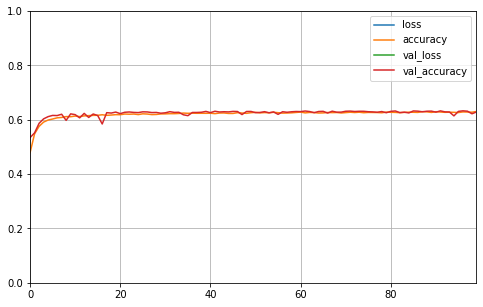

In [26]:
classifier.history()

In [27]:
classifier.test(Xs,ls)

0.37204

__Now we train on the refined lee series:__

In [34]:
np.random.seed(2727)
n = 50000
idx = np.random.permutation(m)[0:n]
# training vectors  
Xs = labeled_timeseries_rl[idx,:-1]*100

classifier = dnn.Dnn([40,40],n_classes,learning_rate=0.002)
classifier.train(Xs,ls,epochs=100)

True

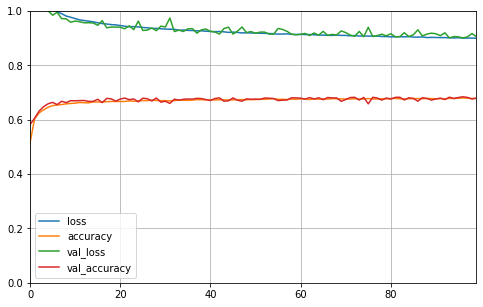

In [35]:
classifier.history()

In [36]:
classifier.test(Xs,ls)

0.3206

In [37]:
cls,probs = classifier.classify(labeled_timeseries_rl[:,0:-1]*100) 
# for later display:
cls[0]=1
cls[1]=n_classes-1

probs.shape

(1440000, 13)

In [38]:
# write the class image to disk
outDataset = driver.Create('imagery/s1atsf/timeseries_rl_class.tif',cols,rows,1,GDT_Byte)
outBand = outDataset.GetRasterBand(1)
outBand.WriteArray(np.reshape(cls,(rows,cols)))
outBand.FlushCache()
outDataset = None
# write the class probabilities to disk
bands = probs.shape[1]
probs = np.byte(probs*255)
outDataset = driver.Create('imagery/s1atsf/timeseries_rl_probs.tif',cols,rows,bands,GDT_Byte)
for b in range(bands):
    outBand = outDataset.GetRasterBand(b+1)
    outBand.WriteArray(np.reshape(probs[:,b],(rows,cols)))
    outBand.FlushCache()
outDataset = None

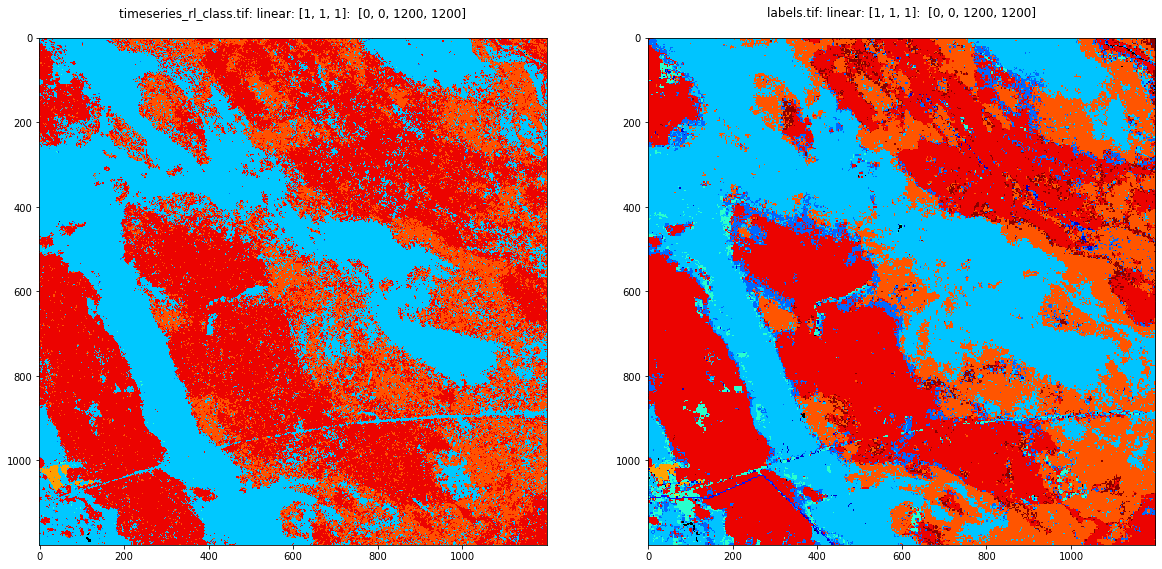

<Figure size 432x288 with 0 Axes>

In [39]:
%run scripts/dispms -f imagery/s1atsf/timeseries_rl_class.tif -c -F imagery/s1atsf/labels.tif -C

#### Now for the atsf series

In [31]:
np.random.seed(2727)
n = 50000
idx = np.random.permutation(m)[0:n]
# training vectors  
Xs = labeled_timeseries_atsf[idx,:-1]*100

classifier = dnn.Dnn([40,40],n_classes,learning_rate=0.002)
classifier.train(Xs,ls,epochs=100)

True

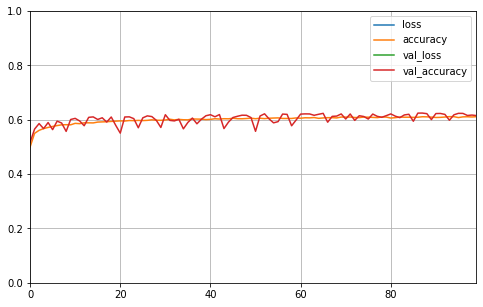

In [32]:
classifier.history()

In [33]:
classifier.test(Xs,ls)

0.38848